In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader
from pathlib import Path
import sys
sys.path.append(str(Path('../../').resolve()))

In [3]:
import torch.optim as optim
optim.lr_scheduler._LRScheduler

torch.optim.lr_scheduler._LRScheduler

In [4]:
%autoreload
import v4.pytorch_unet.unet as unet
from v4.pytorch_unet.learner import LearnerCallback, UNetLearner, UNetLearnerCheckpoint, CycleLRPolicy
from v4.pytorch_unet.unet_dataset import UNetDataset

automatically set env variable CUDA_DEVICE_ORDER to PCI_BUS_ID to set device ordering in pytorch to same ordering as nvidia-smi


In [5]:
train_dataset = UNetDataset(root_dir=Path('simple_dataset'), part='train')
valid_dataset = UNetDataset(root_dir=Path('simple_dataset'), part='valid')
train_loader = DataLoader(train_dataset)
valid_loader = DataLoader(valid_dataset)

In [6]:
model = unet.ResNetUNet(in_channels=train_dataset.image_channels, in_size=train_dataset.item_size,\
                        n_classes=len(train_dataset.classes), depth=4, cuda_devices=[0, 1],\
                       manual_cuda_split=[0, 5])

In [9]:
def handle_epoch_end(metrics, epoch):
    checkpoint = learner.make_checkpoint()
    print('made checkpoint', checkpoint)
    checkpoint.save(Path('test_checkpoints/e_{}'.format(epoch)))
    
callback = LearnerCallback(epoch_end=handle_epoch_end)

lr_policy = CycleLRPolicy(max_lr=3e-3, step_count=100, fadeout_fraction=0.9)

learner = UNetLearner(model_id='test_unet_3', model=model, lr_policy=lr_policy, train_loader=train_loader,\
                      valid_loader=valid_loader, callback=callback)

In [8]:
learner.load_checkpoint(UNetLearnerCheckpoint.load(Path('test_checkpoints/e_9')))

FileNotFoundError: [Errno 2] No such file or directory: 'test_checkpoints/e_9/model.txt'

In [14]:
learner.current_epoch

9

In [15]:
train_dataset[0][1].shape

torch.Size([300, 300])

In [9]:
learner.make_checkpoint

<bound method UNetLearner.make_checkpoint of <v4.pytorch_unet.learner.UNetLearner object at 0x2000ffe87b70>>

In [10]:
learner.train(n_epochs=10, lr=3e-4, momentum=0.9)

Epoch 0
train_loss nan
valid_loss nan
train_accuracy 0.3258059259259259
valid_accuracy 0.3707055555555555
------------------


NameError: name 'lr_scheduler' is not defined

In [46]:
checkpoint = UNetLearnerCheckpoint.load(Path('test_checkpoint'))
learner.load_checkpoint(checkpoint=checkpoint)

/home/h9/adzi885b/clinching-measuring/v4/pytorch_unet/learner.py:284: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(**kwargs)


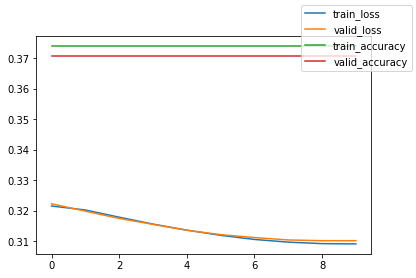

In [9]:
learner.plot_metrics()

In [ ]:
{key: 1 for (key, value) in learner.epoch_metrics.items()}

In [11]:
test = {'train_loss': 0, 'valid_loss': 0, 'accuracy': 0}
{key: value for key, value in enumerate(test)}

{0: 'train_loss', 1: 'valid_loss', 2: 'accuracy'}

In [14]:
plt.ioff()
figure = learner.show_train_results(2)
figure.savefig("test.png")
plt.ion()

In [10]:
torch.load(Path('test_checkpoint/train_history.save'))[0].timestamp

datetime.datetime(2020, 12, 7, 21, 32, 47, 654054)

In [16]:
learner.epoch_metrics

{'train_loss': [0.37691390613714854,
  0.3734049181143443,
  0.3668163905541102,
  0.3606810828049978,
  0.35533954401810963,
  0.35076627333958943,
  0.34711896379788715,
  0.34460744162400564,
  0.3433426340421041,
  0.34302446444829304],
 'valid_loss': [0.3760935217142105,
  0.3699115216732025,
  0.36301159858703613,
  0.35734444856643677,
  0.3523831218481064,
  0.34825339913368225,
  0.34516333043575287,
  0.3433322161436081,
  0.34274253249168396,
  0.3427424877882004],
 'train_accuracy': [0.12602962962962963,
  0.12602962962962963,
  0.1260177777777778,
  0.12599314814814816,
  0.12595518518518517,
  0.1264259259259259,
  0.16471870370370376,
  0.4095599999999999,
  0.3708540740740741,
  0.37223148148148155],
 'valid_accuracy': [0.12929444444444446,
  0.12929444444444446,
  0.12937222222222222,
  0.12975,
  0.1315888888888889,
  0.13833333333333334,
  0.21421666666666672,
  0.35040555555555564,
  0.35592222222222214,
  0.35607222222222223]}

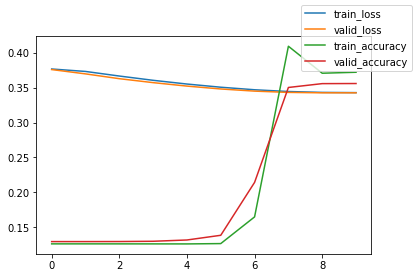

In [17]:
learner.plot_metrics()

In [12]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [27]:
dump_tensors()

Parameter: GPU pinned 2
Parameter: GPU pinned 2 × 2 × 3 × 3
Parameter: GPU pinned 2
Parameter: GPU pinned 2 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 128 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 128 × 64 × 2 × 2
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 256 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 256 × 128 × 2 × 2
Tensor: GPU pinned 64 × 1 × 3 × 3
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64 × 64 × 3 × 3
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64 × 64 × 3 × 3
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64 × 64 × 3 × 3
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64
Tensor: GPU pinned 64

In [51]:
torch.cuda.empty_cache()

In [52]:
del learner

In [53]:
from v4.pytorch_unet.gpu_stats import get_gpu_stats
get_gpu_stats(0)

OrderedDict([('time', 1607900491.8460016),
             ('gpu_util', 0),
             ('mem_used', 2266),
             ('mem_used_per', 20.284665652134994)])